<h1>Лабораторная работа 4</h1>
<h2>Деревья решений</h2>

Выполнил: 6131 Чаплыгин Алексей Олегович

Выберите набор данных для классификации (бинарной или многоклассовой — не важно). Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений. В общем, проведите "визуальный" анализ ваших данных.
<ol>
    <li>Для вашего датасета преобразовать категориальные признаки в бинарные с помощью pd.factorize / pd.get_dummies</li>
    <li>С помощью sklearn.preprocessing.StandardScaler нормализовать значения признаков и построить для нормализованного датасета KNeighborsClassifier (без использования конвееров)</li>
    <li>То же самое и использованием sklearn.pipeline.Pipeline</li>
    <li>С помощью GridSearchCV произвести подбор гиперпараметра KNeighborsClassifier (n_neighbors) и выведите значение гиперпараметра и метрику для наилучшей модели</li>
</ol>

<h2>0. Набор данных</h2>
Выберите набор данных для классификации (бинарной или многоклассовой — не важно). Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений. В общем, проведите "визуальный" анализ ваших данных.. В общем, проведите "визуальный" анализ ваших данных.</br>
Используемый в работе набор данных доступен по следующей ссылке: https://www.kaggle.com/rankirsh/evolution-of-top-games-on-twitch и описывает рейтинг популярных 200 игр, транслируемых на платформе Twitch с 2016 по 2021 года.
В наборе данных содержится таблица с 12 столбцами.</br>
<table border="1">
   <caption>Top games on Twitch 2016 - 2021</caption>
   <tr>
    <th>Номер столбца</th>
    <th>Название столбца</th>
    <th>Описание столбца</th>
   </tr>
   <tr><td>1</td><td>Rank</td><td>Значение рейтинга</td></tr>
   <tr><td>2</td><td>Game</td><td>Наименование игры</td></tr>
   <tr><td>3</td><td>Month</td><td>Месяц</td></tr>
   <tr><td>4</td><td>Year</td><td>Год</td></tr>
   <tr><td>5</td><td>Hours_watched</td><td>Колчествао часов, которое зрители смотрели</td></tr>
   <tr><td>6</td><td>Hours_Streamed</td><td>Количество часов, которое стримеры стримили</td></tr>
   <tr><td>7</td><td>Peak_viewers</td><td>Максимальное количество зрителей</td></tr>
   <tr><td>8</td><td>Peak_channels</td><td>Максимальное количество каналов на которых происходила трансляция одновременно</td></tr>
   <tr><td>9</td><td>Streamers</td><td>Всего стримеров, которые стримили эту игру</td></tr>
   <tr><td>10</td><td>Avg_viewers</td><td>Среднее количество просмотров</td></tr>
   <tr><td>11</td><td>Avg_channels</td><td>Среднее количество каналов</td></tr>
   <tr><td>12</td><td>Avg_viewer_ratio</td><td>Средний коэффициент просмотров</td></tr>
  </table>

In [1]:
# PRE INIT ROW
# for new libraries if need
# !pip install 

In [2]:
# INIT IMPORT
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import probplot

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, confusion_matrix, accuracy_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

In [3]:
# MAIN FUNCS

# Функция условной бинарной градации записей на основании рейтига
def binary_ratio(r):
    if r > 10000 :
        c = 'High'
    else:
        c = 'Low'
    return c

In [4]:
data = pd.read_csv('data/Twitch_game_data.csv', sep=',', encoding='windows-1251')
data.head()

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,1,League of Legends,1,2016,94377226,1362044 hours,530270,2903,129172,127021,1833,69.29
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105 hours,372654,2197,120849,64378,1117,57.62
2,3,Dota 2,1,2016,45185893,433397 hours,315083,1100,44074,60815,583,104.26
3,4,Hearthstone,1,2016,39936159,235903 hours,131357,517,36170,53749,317,169.29
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578 hours,71639,3620,214054,21740,1549,14.03


In [5]:
# Преобразуем данные и добавляем условыне классы на основании рейтинга Avg_viewer_ratio, где High - высокий и Low - низний рейтинги средего просмотра контента.
data_binary = data.copy()
data_binary['Hours_Streamed'] = data_binary.apply(lambda x: x['Hours_Streamed'].replace(' hours', '') , axis=1)
data_binary['Binary_Ratio'] = data_binary.apply(lambda row: binary_ratio(row['Avg_viewer_ratio']), axis = 1)
data_binary = data_binary.drop(columns = ['Game', 'Rank'], axis = 1)

data_binary.head()

,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Binary_Ratio
0,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69.29,Low
1,1,2016,47832863,830105,372654,2197,120849,64378,1117,57.62,Low
2,1,2016,45185893,433397,315083,1100,44074,60815,583,104.26,Low
3,1,2016,39936159,235903,131357,517,36170,53749,317,169.29,Low
4,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14.03,Low


<h2>1.0. Для вашего датасета преобразовать категориальные признаки в бинарные с помощью pd.factorize / pd.get_dummies</h2>

In [6]:
factor = pd.factorize(data_binary['Binary_Ratio'])
data_binary.Binary_Ratio = factor[0]
definitions = factor[1]

print(data_binary.Binary_Ratio.head())
print(definitions)

0    0
1    0
2    0
3    0
4    0
Name: Binary_Ratio, dtype: int64
Index(['Low', 'High'], dtype='object')


<h2>1.1. С помощью sklearn.preprocessing.StandardScaler нормализовать значения признаков и построить для нормализованного датасета KNeighborsClassifier (без использования конвееров)</h2>
Разделим набор данных на независимые и зависимые переменные.<br>
Все столбцы (без предпоследнего) являются независимыми переменными.<br>
Cтолбец "Binary_Ratio" - будет зависимой переменной.<br>
Сохраняем как массив.

In [7]:
X = data_binary.iloc[:, 0:10].values
X

array([[1, 2016, 94377226, ..., 127021, 1833, 69.29],
       [1, 2016, 47832863, ..., 64378, 1117, 57.62],
       [1, 2016, 45185893, ..., 60815, 583, 104.26],
       ...,
       [12, 2021, 620983, ..., 835, 18, 44.56],
       [12, 2021, 619859, ..., 834, 0, 1022.87],
       [12, 2021, 615725, ..., 828, 56, 14.56]], dtype=object)

In [8]:
Y = data_binary.iloc[:, 10].values
Y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 25)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# пусть для 13 соседей
   
model_KNBC = KNeighborsClassifier(n_neighbors = 13)
    
model_KNBC.fit(X_train, Y_train)
Y_KNBC = model_KNBC.predict(X_test)

# accuracy
print (f'Accuracy = {accuracy_score(Y_test, Y_KNBC) * 100}%')

Accuracy = 99.97222222222221%


<h2>1.2. То же самое и использованием sklearn.pipeline.Pipeline</h2>
Cоздаём массив последовательности «шагов» конвейера.<br>
Сначала необходимо стандартизировать данные, а уже затем выполнить предсказание.

In [10]:
scaler = StandardScaler()
KNBC = KNeighborsClassifier()

steps = [('normalizer', scaler), ('KNBC', KNBC)]
pipe = Pipeline(steps)

In [11]:
pipe

Pipeline(steps=[('normalizer', StandardScaler()),
                ('KNBC', KNeighborsClassifier())])

<h2>1.3. С помощью GridSearchCV произвести подбор гиперпараметра KNeighborsClassifier (n_neighbors) и выведите значение гиперпараметра и метрику для наилучшей модели.</h2>
<b>Гиперпараметры</b> - настраиваемые параметры, которые необходимо настроить, чтобы получить модель с оптимальными характеристиками.<br>
Для <b>KNeighborsClassifier</b>:
<ul>
    <li>n_neighbors - это количество соседей, которые нужно использовать</li>
    <li>weights - весовая функция,используемая при прогнозировании</li>
    <li>algorithm - алгоритм, используемый для вычисления ближайших соседей</li>
</ul> 

In [12]:
params_KNBC = \
     {'KNBC__n_neighbors': np.arange(5, 50), 
     'KNBC__weights': ['uniform', 'distance'], 
     'KNBC__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_search_KNBC = GridSearchCV(pipe, params_KNBC)
grid_search_KNBC.fit(X_train, Y_train)

GridSearchCV(estimator=Pipeline(steps=[('normalizer', StandardScaler()),
                                       ('KNBC', KNeighborsClassifier())]),
             param_grid={'KNBC__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                             'brute'],
                         'KNBC__n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'KNBC__weights': ['uniform', 'distance']})

In [13]:
print(f'Score: {grid_search_KNBC.score(X_test, Y_test)}')
grid_search_KNBC.best_params_

Score: 0.9997222222222222


{'KNBC__algorithm': 'auto', 'KNBC__n_neighbors': 5, 'KNBC__weights': 'uniform'}

<h2>2.1. Продемонстрировать работу DecisionTreeClassifier, посчитать метрики качества на отложенной выборке</h2>

In [14]:
DTC = DecisionTreeClassifier()
DTC.fit(X_train, Y_train)
# accuracy
print (f'Accuracy = {accuracy_score(Y_test, DTC.predict(X_test)) * 100}%')

Accuracy = 100.0%


<h2>2.2. С помощью GridSearchCV произвести подбор гиперпараметров для поиска наилучшего дерева</h2>
Гиперпараметры: max_depth, max_features

In [15]:
scaler = StandardScaler()

steps_DTC = [('normalizer', scaler), ('DTC', DTC)]
pipe_DTC = Pipeline(steps_DTC)

params_DTC = \
     {'DTC__max_depth': np.arange(1, 10),
     'DTC__splitter': ['best', 'random'],
     'DTC__criterion': ['gini', 'entropy'],
     'DTC__max_features': ['auto', 'sqrt', 'log2']}

grid_search_DTC = GridSearchCV(pipe_DTC, params_DTC)

grid_search_DTC.fit(X_train, Y_train)

GridSearchCV(estimator=Pipeline(steps=[('normalizer', StandardScaler()),
                                       ('DTC', DecisionTreeClassifier())]),
             param_grid={'DTC__criterion': ['gini', 'entropy'],
                         'DTC__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DTC__max_features': ['auto', 'sqrt', 'log2'],
                         'DTC__splitter': ['best', 'random']})

In [16]:
print(f'Score: {grid_search_DTC.score(X_test, Y_test)}')
grid_search_DTC.best_params_

Score: 0.9997222222222222


{'DTC__criterion': 'gini',
 'DTC__max_depth': 2,
 'DTC__max_features': 'auto',
 'DTC__splitter': 'best'}

<h2>2.3. Для полученного наилучшего дерева построить график feature_importances</h2>
дополнительно напечатать 3 наиболее важных признака, отсортировав их по убыванию важности

In [17]:
print(DTC.feature_importances_)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

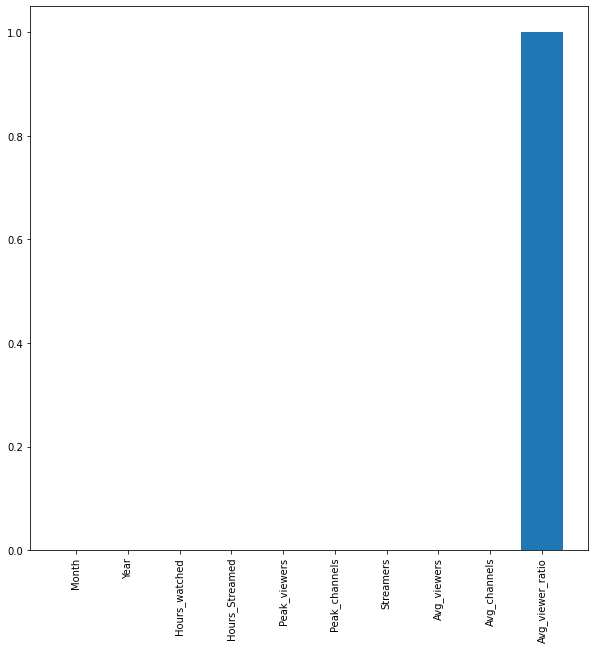

In [22]:
plt.figure(figsize=(10,10))
plt.bar(data_binary.columns[0:10], DTC.feature_importances_)
plt.xticks(rotation=90)

In [25]:
# признак - значимость
l = np.vstack([DTC.feature_importances_, data_binary.columns[0:10]]).T

In [27]:
# сортируем
sorted(l, key = lambda x: x[0], reverse=True)

[array([1.0, 'Avg_viewer_ratio'], dtype=object),
 array([0.0, 'Month'], dtype=object),
 array([0.0, 'Year'], dtype=object),
 array([0.0, 'Hours_watched'], dtype=object),
 array([0.0, 'Hours_Streamed'], dtype=object),
 array([0.0, 'Peak_viewers'], dtype=object),
 array([0.0, 'Peak_channels'], dtype=object),
 array([0.0, 'Streamers'], dtype=object),
 array([0.0, 'Avg_viewers'], dtype=object),
 array([0.0, 'Avg_channels'], dtype=object)]

<h2>3.1. Продемонстрировать работу случайного леса RandomForestClassifier</h2>

In [28]:
RFC = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
RFC.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [29]:
print (f'Accuracy = {accuracy_score(Y_test, RFC.predict(X_test)) * 100}%')

Accuracy = 99.97222222222221%


<h2>3.2. С помощью GridSearchCV произвести подбор гиперпараметров для поиск наилучшего леса, посмотреть насколько улучшились метрики</h2>

In [30]:
scaler = StandardScaler()

steps_RFC = [('normalizer', scaler), ('RFC', RFC)]
pipe_RFC = Pipeline(steps_RFC)

params_RFC = \
     {'RFC__n_estimators': np.arange(10, 100),
     'RFC__criterion': ['gini', 'entropy'],
     'RFC__max_features': ['auto', 'sqrt', 'log2']}
grid_search_RFC = GridSearchCV(pipe_RFC, params_RFC)

grid_search_RFC.fit(X_train, Y_train)

GridSearchCV(estimator=Pipeline(steps=[('normalizer', StandardScaler()),
                                       ('RFC',
                                        RandomForestClassifier(criterion='entropy',
                                                               n_estimators=10,
                                                               random_state=42))]),
             param_grid={'RFC__criterion': ['gini', 'entropy'],
                         'RFC__max_features': ['auto', 'sqrt', 'log2'],
                         'RFC__n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99])})

In [31]:
print(grid_search_RFC.score(X_test, Y_test))
grid_search_RFC.best_params_

0.9997222222222222


{'RFC__criterion': 'gini',
 'RFC__max_features': 'auto',
 'RFC__n_estimators': 10}

<h2>Вывод</h2>
Какой классификатор и с камими гиперпараметрами дал в итоге наилучший результат для выбранного датасета на отложенной выборке.</br>

In [35]:
# 1.1. С помощью sklearn.preprocessing.StandardScaler нормализовать значения признаков и построить для нормализованного датасета KNeighborsClassifier (без использования конвееров)
print (f'KNeighborsClassifier Accuracy = {accuracy_score(Y_test, Y_KNBC) * 100}%')
# 1.3. С помощью GridSearchCV произвести подбор гиперпараметра KNeighborsClassifier (n_neighbors) и выведите значение гиперпараметра и метрику для наилучшей модели.¶
print(f'Score: {grid_search_KNBC.score(X_test, Y_test)}')
grid_search_KNBC.best_params_

KNeighborsClassifier Accuracy = 99.97222222222221%
Score: 0.9997222222222222


{'KNBC__algorithm': 'auto', 'KNBC__n_neighbors': 5, 'KNBC__weights': 'uniform'}

In [36]:
# 2.1. Продемонстрировать работу DecisionTreeClassifier, посчитать метрики качества на отложенной выборке
print (f'DecisionTreeClassifier Accuracy = {accuracy_score(Y_test, DTC.predict(X_test)) * 100}%')
# 2.2. С помощью GridSearchCV произвести подбор гиперпараметров для поиска наилучшего дерева
print(f'GridSearchCV Tree Score: {grid_search_DTC.score(X_test, Y_test)}')
grid_search_DTC.best_params_

DecisionTreeClassifier Accuracy = 100.0%
GridSearchCV Tree Score: 0.9997222222222222


{'DTC__criterion': 'gini',
 'DTC__max_depth': 2,
 'DTC__max_features': 'auto',
 'DTC__splitter': 'best'}

In [37]:
# 3.1. Продемонстрировать работу случайного леса RandomForestClassifier
print (f'RandomForestClassifier Accuracy = {accuracy_score(Y_test, RFC.predict(X_test)) * 100}%')
# 3.2. С помощью GridSearchCV произвести подбор гиперпараметров для поиск наилучшего леса, посмотреть насколько улучшились метрики
print(f'GridSearchCV Forest Score: {grid_search_RFC.score(X_test, Y_test)}')
grid_search_RFC.best_params_

RandomForestClassifier Accuracy = 99.97222222222221%
GridSearchCV Forest Score: 0.9997222222222222


{'RFC__criterion': 'gini',
 'RFC__max_features': 'auto',
 'RFC__n_estimators': 10}

Лучший результат на основании Accuracy дал классификатор <b>DecisionTreeClassifier</b> с параметрами:
<ul>
    <li>criterion: gini</li>
    <li>max_depth: 2</li>
    <li>max_features: auto</li>
    <li>splitter: best</li>
</ul> 
Хотя <b>Score</b> у всех равен <b>0.9997222222222222</b> так что я не уверен в корректности анализа.